In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from skimage.io import imread, imshow
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
import keras.callbacks
from keras.callbacks import ModelCheckpoint
import random
from keras.applications import vgg16
from keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

C:\Users\sandl\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\sandl\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
train_dir = 'Downloads/seg_train'
test_dir = 'Downloads/seg_test'
pred_dir = 'Downloads/seg_pred'

In [3]:
class_names = ['buildings','forest','glacier','mountain','sea','street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

number_classes = len(class_names)

IMAGE_SIZE = (150,150)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [4]:
for folder in os.listdir(train_dir):
    files_path = []
    for file in os.listdir(os.path.join(train_dir,folder)):
        files_path.append(file)
    print(len(files_path))

2191
2271
2404
2512
2274
2382


In [5]:
def load_dataset():
    # create list of datasets
    datasets = [train_dir, test_dir]
    output = []
    
    for dataset in datasets:
        
        images1 = []
        labels1 = []
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            # assign labels to each folder images
            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)
                # read the image files stored in image_path
                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                image_file = cv2.resize(image_file, IMAGE_SIZE)
                
                images1.append(image_file)
                labels1.append(label)
                
        # convert the images and labels list to numpy array
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')
        
        output.append((images1, labels1))
        print("Images file have been loaded")
                
    return output 

In [6]:
((train_images, train_labels), (test_images, test_labels)) = load_dataset()

loading Downloads/seg_train


100%|████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:01<00:00, 1234.24it/s]


Images file have been loaded
loading Downloads/seg_test


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:09<00:00, 54.72it/s]


Images file have been loaded


In [7]:
print("train dataset size")
len(train_images), len(train_labels)

train dataset size


(14034, 14034)

In [8]:
print("test dataset size")
len(test_images), len(test_labels)

test dataset size


(3000, 3000)

In [9]:
train_images.shape, test_images.shape

((14034, 150, 150, 3), (3000, 150, 150, 3))

In [10]:
(train_images, train_labels) = shuffle(train_images, train_labels, random_state=45)
(test_images, test_labels) = shuffle(test_images, test_labels, random_state=45)

In [11]:
train_images = train_images[:6000]
train_labels = train_labels[:6000]
test_images = test_images[:1400]
test_labels = test_labels[:1400]
trn_images_norm = train_images/255.0
tst_images_norm = test_images/255.0

In [12]:
def proportion_labels(labels, dataset):
    series = pd.DataFrame(labels).reset_index()
    series.rename(columns = {0:'labels'}, inplace=True)
    final_s = series.groupby('labels').count().reset_index()                                          
    ticks1= [key for key in class_labels.keys()]
    
    # plot the pie chart and bar graph of labels
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.bar(np.array(final_s['labels']), np.array(final_s['index']))
    plt.xticks(ticks=np.array(final_s['labels']), labels=ticks1, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.grid(visible=True)
    plt.title("Number of images per class", size=14, weight='bold')
    
    plt.subplot(122)
    plt.pie(final_s['index'].ravel(),
            labels=ticks1,
            autopct='%1.2f%%',
            textprops={'fontweight':'bold'}
           )
    plt.title("proportion of classes", size=14, weight='bold')
    
    plt.suptitle(f"Proportion of {dataset} data", size=20, weight='bold')
    plt.show()
    
    return final_s

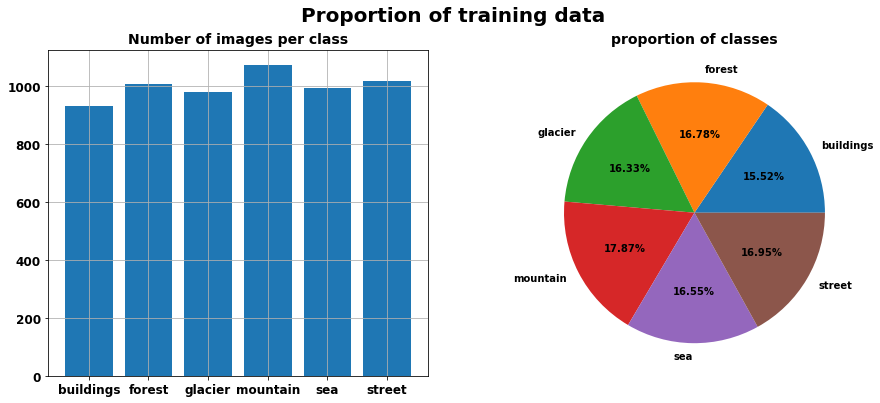

In [13]:
final_s = proportion_labels(train_labels, "training")

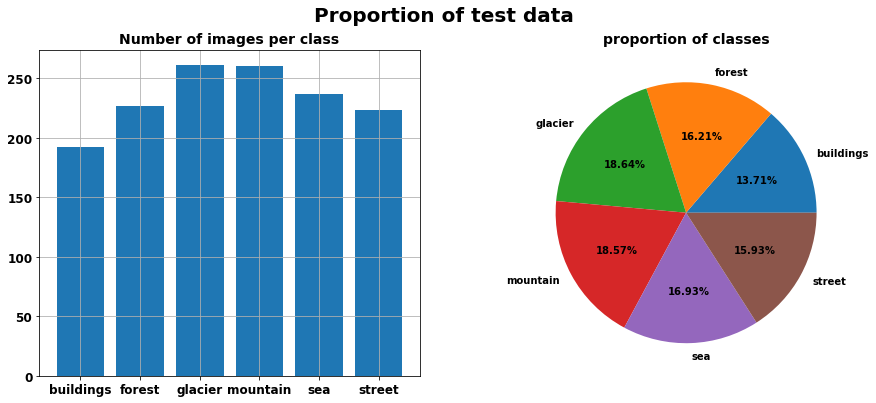

In [14]:
test_d = proportion_labels(test_labels, "test")

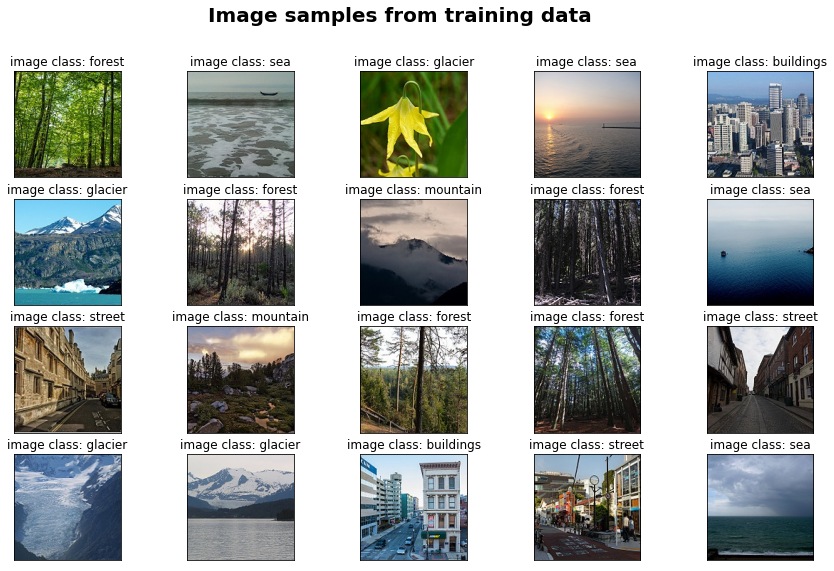

In [17]:
plt.figure(figsize=(15,9))
for idx, label in enumerate(train_labels[:20]):
    plt.subplot(4,5, idx+1)
    plt.imshow(trn_images_norm[idx])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'image class: {class_names[label]}')   
    
plt.suptitle(f'Image samples from training data', size=20, weight='bold')
plt.show()

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [19]:
# convert labels to categorical 
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# compile the model with 'adam' optimizer
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(trn_images_norm, train_labels, batch_size=128, epochs=15, validation_data=(tst_images_norm, test_labels),
                   callbacks=callback_list)

# evalute the model
test_loss, test_acc = model.evaluate(tst_images_norm, test_labels, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
47/47 [==============================] - ETA: 0s - loss: 1.4907 - accuracy: 0.3843INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 149s 3s/step - loss: 1.4907 - accuracy: 0.3843 - val_loss: 1.2469 - val_accuracy: 0.4864
Epoch 2/15
47/47 [==============================] - ETA: 0s - loss: 1.1463 - accuracy: 0.5360INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 107s 2s/step - loss: 1.1463 - accuracy: 0.5360 - val_loss: 1.1399 - val_accuracy: 0.5429
Epoch 3/15
47/47 [==============================] - ETA: 0s - loss: 1.0312 - accuracy: 0.5737INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 107s 2s/step - loss: 1.0312 - accuracy: 0.5737 - val_loss: 0.9594 - val_accuracy: 0.6307
Epoch 4/15
47/47 [==============================] - ETA: 0s - loss: 0.9351 - accuracy: 0.6287INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 104s 2s/step - loss: 0.9351 - accuracy: 0.6287 - val_loss: 0.9057 - val_accuracy: 0.6486
Epoch 5/15
47/47 [==============================] - ETA: 0s - loss: 0.8505 - accuracy: 0.6688INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 103s 2s/step - loss: 0.8505 - accuracy: 0.6688 - val_loss: 0.8280 - val_accuracy: 0.6929
Epoch 6/15
47/47 [==============================] - ETA: 0s - loss: 0.7931 - accuracy: 0.6992INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 104s 2s/step - loss: 0.7931 - accuracy: 0.6992 - val_loss: 0.8083 - val_accuracy: 0.7000
Epoch 7/15
47/47 [==============================] - ETA: 0s - loss: 0.7441 - accuracy: 0.7238INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 106s 2s/step - loss: 0.7441 - accuracy: 0.7238 - val_loss: 0.7690 - val_accuracy: 0.7121
Epoch 8/15
47/47 [==============================] - 101s 2s/step - loss: 0.7045 - accuracy: 0.7297 - val_loss: 0.7843 - val_accuracy: 0.7236
Epoch 9/15
47/47 [==============================] - ETA: 0s - loss: 0.6823 - accuracy: 0.7403INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 106s 2s/step - loss: 0.6823 - accuracy: 0.7403 - val_loss: 0.7205 - val_accuracy: 0.7336
Epoch 10/15
47/47 [==============================] - 103s 2s/step - loss: 0.6708 - accuracy: 0.7510 - val_loss: 0.7433 - val_accuracy: 0.6979
Epoch 11/15
47/47 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.7728INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 103s 2s/step - loss: 0.6209 - accuracy: 0.7728 - val_loss: 0.6693 - val_accuracy: 0.7543
Epoch 12/15
47/47 [==============================] - ETA: 0s - loss: 0.5851 - accuracy: 0.7855INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 102s 2s/step - loss: 0.5851 - accuracy: 0.7855 - val_loss: 0.6649 - val_accuracy: 0.7600
Epoch 13/15
47/47 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.7913INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 101s 2s/step - loss: 0.5727 - accuracy: 0.7913 - val_loss: 0.6361 - val_accuracy: 0.7700
Epoch 14/15
47/47 [==============================] - 102s 2s/step - loss: 0.5566 - accuracy: 0.7935 - val_loss: 0.6528 - val_accuracy: 0.7721
Epoch 15/15
47/47 [==============================] - 101s 2s/step - loss: 0.5350 - accuracy: 0.8045 - val_loss: 0.6489 - val_accuracy: 0.7657
test loss and accuracy: 0.6488564014434814 0.7657142877578735


In [20]:
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

images_paths = getImagePaths(pred_dir)
len(images_paths)

7301

In [21]:
file_array = []

for file in images_paths[:9]:
    files = cv2.imread(file)/255.0 
    file_array.append(files)
    
file_array = np.array(file_array)

In [22]:
predictions = model.predict(file_array)
predictions.shape

1/1 [==============================] - 1s 1s/step


(9, 6)

In [23]:
preds_index = np.argmax(predictions, axis=1)
preds_index

array([5, 3, 0, 3, 2, 1, 4, 2, 3], dtype=int64)

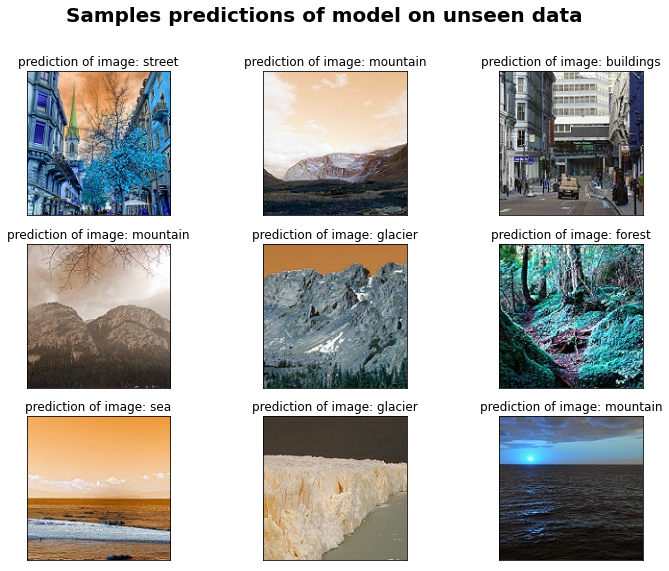

In [24]:
plt.figure(figsize=(12,9))

for idx, i in enumerate(preds_index):
    plt.subplot(3,3, idx+1)
    plt.imshow(file_array[idx])
    plt.title(f"prediction of image: {class_names[i]}")
    plt.xticks([])
    plt.yticks([])
    
plt.suptitle("Samples predictions of model on unseen data", size=20, weight='bold')
plt.show()

In [25]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

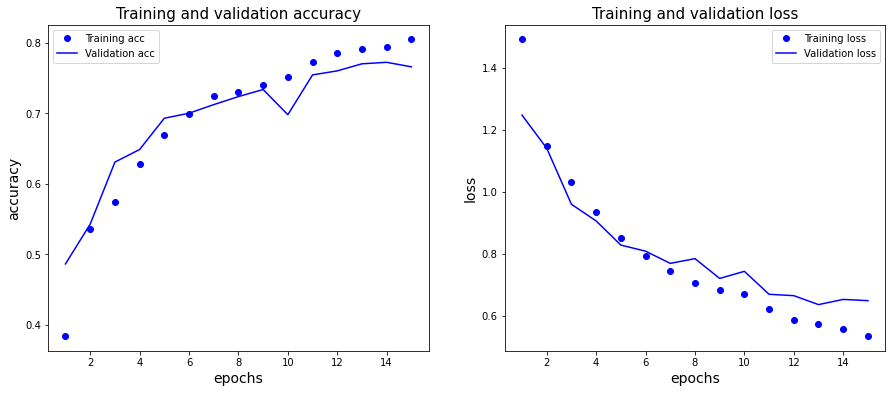

In [26]:
plot_loss_accuracy(history)

In [27]:
# prediction on validation data to check the errors
preds = model.predict(tst_images_norm)
print("Shape of the prediction indexs", preds.shape)

# apply argmax function over a rows to find 
predictions_f = np.argmax(preds, axis=1)
print("Shape of predicitons vector:", predictions_f.shape)

44/44 [==============================] - 7s 164ms/step
Shape of the prediction indexs (1400, 6)
Shape of predicitons vector: (1400,)


In [28]:
# convert categorical test labels to numpy array of 1 dim
test_list = []
for i in test_labels:
    index1 = list(np.argwhere(i).reshape(1))[0]
    test_list.append(index1)

test_array = np.array(test_list)
print("shape of actual test array:", test_array.shape)

shape of actual test array: (1400,)


In [29]:
def mislabled_images(class_names, test_images, test_labels, predicted_labels):
    # find the  mislabeled images using np.where and return array of mislabled images
    mislabels = (test_labels == predicted_labels)
    mislabels_index = np.array(np.where(mislabels == False)).ravel()
    mislables_images = test_images[mislabels_index]
    mislables_labels = predicted_labels[mislabels_index]
    
    print("Number of total mislabeled images", mislables_labels.shape)
    
    # plot the 20 mislabeled images
    plt.figure(figsize=(15,9))
    for idx, label in enumerate(mislables_labels[:20]):
        plt.subplot(4,5, idx+1)
        plt.imshow(mislables_images[idx])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Predicted class: {class_names[label]}')   
    
        plt.suptitle(f'Mislabeled images from test data', size=20, weight='bold')
    plt.show()  
    return mislables_labels

Number of total mislabeled images (328,)


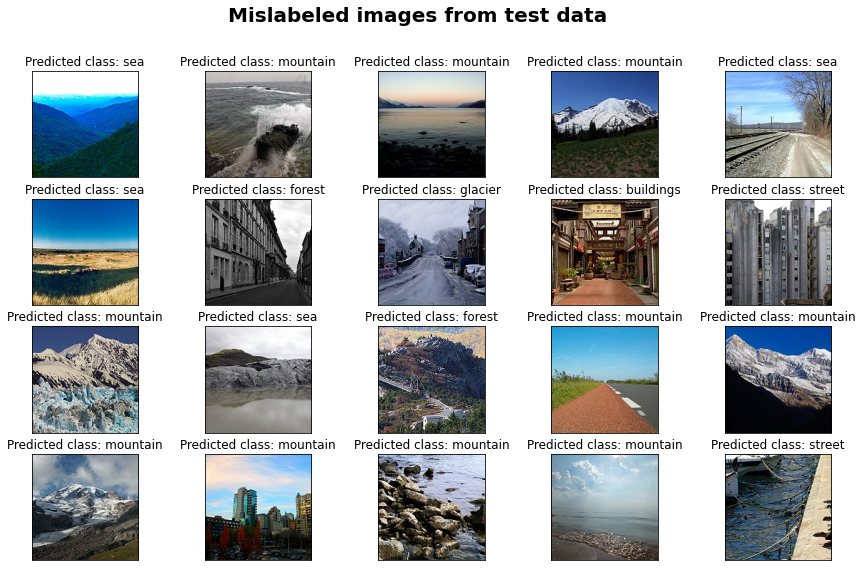

In [30]:
mislables_labels = mislabled_images(class_names, tst_images_norm, test_array, predictions_f)

In [31]:
conv_base = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3)
                 )

conv_base.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [32]:
train_featuremap = conv_base.predict(trn_images_norm)
test_featuremap = conv_base.predict(tst_images_norm) 
# print the shape of output tensors from convolutionla base -vgg16
train_featuremap.shape, test_featuremap.shape

44/44 [==============================] - 160s 4s/step


((6000, 4, 4, 512), (1400, 4, 4, 512))

In [33]:
model2 = models.Sequential()
model2.add(layers.Flatten(input_shape=(4,4,512)))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(6, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 2098950 (8.01 MB)
Trainable params: 2098950 (8.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
model2.compile(loss='categorical_crossentropy',
             optimizer= tf.keras.optimizers.RMSprop(learning_rate=2e-5),
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

In [35]:
result = model2.fit(train_featuremap, train_labels,
                   batch_size=128,
                   epochs=30,
                   validation_data=(test_featuremap, test_labels),
                   callbacks=callback_list
                   )

# print the final test accuracy and loss
tst_loss, tst_acc = model2.evaluate(test_featuremap, test_labels, verbose=0)
print("Test loss and accuracy of model2:", tst_loss, tst_acc)

Epoch 1/30
47/47 [==============================] - ETA: 0s - loss: 1.5130 - accuracy: 0.3993INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 25s 407ms/step - loss: 1.5130 - accuracy: 0.3993 - val_loss: 1.0429 - val_accuracy: 0.7343
Epoch 2/30
46/47 [============================>.] - ETA: 0s - loss: 0.9693 - accuracy: 0.6714INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 57ms/step - loss: 0.9680 - accuracy: 0.6720 - val_loss: 0.7356 - val_accuracy: 0.7936
Epoch 3/30
47/47 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.7553INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 60ms/step - loss: 0.7313 - accuracy: 0.7553 - val_loss: 0.6042 - val_accuracy: 0.8186
Epoch 4/30
47/47 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.7837INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 63ms/step - loss: 0.6288 - accuracy: 0.7837 - val_loss: 0.5344 - val_accuracy: 0.8307
Epoch 5/30
47/47 [==============================] - ETA: 0s - loss: 0.5643 - accuracy: 0.8042INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 63ms/step - loss: 0.5643 - accuracy: 0.8042 - val_loss: 0.4966 - val_accuracy: 0.8293
Epoch 6/30
47/47 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.8250INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 59ms/step - loss: 0.5130 - accuracy: 0.8250 - val_loss: 0.4696 - val_accuracy: 0.8393
Epoch 7/30
47/47 [==============================] - ETA: 0s - loss: 0.4791 - accuracy: 0.8347INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 55ms/step - loss: 0.4791 - accuracy: 0.8347 - val_loss: 0.4447 - val_accuracy: 0.8464
Epoch 8/30
46/47 [============================>.] - ETA: 0s - loss: 0.4601 - accuracy: 0.8405INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 56ms/step - loss: 0.4595 - accuracy: 0.8412 - val_loss: 0.4280 - val_accuracy: 0.8464
Epoch 9/30
47/47 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.8522INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 69ms/step - loss: 0.4397 - accuracy: 0.8522 - val_loss: 0.4154 - val_accuracy: 0.8529
Epoch 10/30
47/47 [==============================] - ETA: 0s - loss: 0.4199 - accuracy: 0.8540INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 2s 52ms/step - loss: 0.4199 - accuracy: 0.8540 - val_loss: 0.4040 - val_accuracy: 0.8514
Epoch 11/30
46/47 [============================>.] - ETA: 0s - loss: 0.3935 - accuracy: 0.8645INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 55ms/step - loss: 0.3938 - accuracy: 0.8645 - val_loss: 0.3977 - val_accuracy: 0.8529
Epoch 12/30
46/47 [============================>.] - ETA: 0s - loss: 0.3880 - accuracy: 0.8645INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 54ms/step - loss: 0.3893 - accuracy: 0.8635 - val_loss: 0.3918 - val_accuracy: 0.8521
Epoch 13/30
47/47 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.8710INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 58ms/step - loss: 0.3741 - accuracy: 0.8710 - val_loss: 0.3849 - val_accuracy: 0.8550
Epoch 14/30
47/47 [==============================] - ETA: 0s - loss: 0.3671 - accuracy: 0.8713INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 2s 52ms/step - loss: 0.3671 - accuracy: 0.8713 - val_loss: 0.3782 - val_accuracy: 0.8607
Epoch 15/30
46/47 [============================>.] - ETA: 0s - loss: 0.3540 - accuracy: 0.8796INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 54ms/step - loss: 0.3544 - accuracy: 0.8800 - val_loss: 0.3752 - val_accuracy: 0.8636
Epoch 16/30
47/47 [==============================] - ETA: 0s - loss: 0.3503 - accuracy: 0.8807INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 2s 53ms/step - loss: 0.3503 - accuracy: 0.8807 - val_loss: 0.3676 - val_accuracy: 0.8650
Epoch 17/30
46/47 [============================>.] - ETA: 0s - loss: 0.3366 - accuracy: 0.8845INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 54ms/step - loss: 0.3362 - accuracy: 0.8847 - val_loss: 0.3650 - val_accuracy: 0.8650
Epoch 18/30
46/47 [============================>.] - ETA: 0s - loss: 0.3366 - accuracy: 0.8835INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 67ms/step - loss: 0.3366 - accuracy: 0.8832 - val_loss: 0.3642 - val_accuracy: 0.8636
Epoch 19/30
46/47 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8923INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 59ms/step - loss: 0.3197 - accuracy: 0.8932 - val_loss: 0.3595 - val_accuracy: 0.8693
Epoch 20/30
46/47 [============================>.] - ETA: 0s - loss: 0.3241 - accuracy: 0.8908INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 61ms/step - loss: 0.3228 - accuracy: 0.8920 - val_loss: 0.3559 - val_accuracy: 0.8671
Epoch 21/30
47/47 [==============================] - ETA: 0s - loss: 0.3077 - accuracy: 0.9002INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 60ms/step - loss: 0.3077 - accuracy: 0.9002 - val_loss: 0.3530 - val_accuracy: 0.8721
Epoch 22/30
47/47 [==============================] - 2s 33ms/step - loss: 0.3069 - accuracy: 0.8953 - val_loss: 0.3537 - val_accuracy: 0.8621
Epoch 23/30
47/47 [==============================] - ETA: 0s - loss: 0.2934 - accuracy: 0.9022INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 4s 80ms/step - loss: 0.2934 - accuracy: 0.9022 - val_loss: 0.3483 - val_accuracy: 0.8700
Epoch 24/30
46/47 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.8993INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 54ms/step - loss: 0.2920 - accuracy: 0.8997 - val_loss: 0.3447 - val_accuracy: 0.8714
Epoch 25/30
47/47 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.9032INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 65ms/step - loss: 0.2881 - accuracy: 0.9032 - val_loss: 0.3418 - val_accuracy: 0.8729
Epoch 26/30
47/47 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.9090INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 56ms/step - loss: 0.2809 - accuracy: 0.9090 - val_loss: 0.3417 - val_accuracy: 0.8714
Epoch 27/30
47/47 [==============================] - ETA: 0s - loss: 0.2778 - accuracy: 0.9080INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 2s 52ms/step - loss: 0.2778 - accuracy: 0.9080 - val_loss: 0.3396 - val_accuracy: 0.8729
Epoch 28/30
46/47 [============================>.] - ETA: 0s - loss: 0.2697 - accuracy: 0.9098INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 3s 56ms/step - loss: 0.2705 - accuracy: 0.9093 - val_loss: 0.3378 - val_accuracy: 0.8721
Epoch 29/30
47/47 [==============================] - 2s 33ms/step - loss: 0.2678 - accuracy: 0.9117 - val_loss: 0.3382 - val_accuracy: 0.8714
Epoch 30/30
47/47 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.9155INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


47/47 [==============================] - 2s 53ms/step - loss: 0.2591 - accuracy: 0.9155 - val_loss: 0.3349 - val_accuracy: 0.8721
Test loss and accuracy of model2: 0.33489012718200684 0.8721428513526917


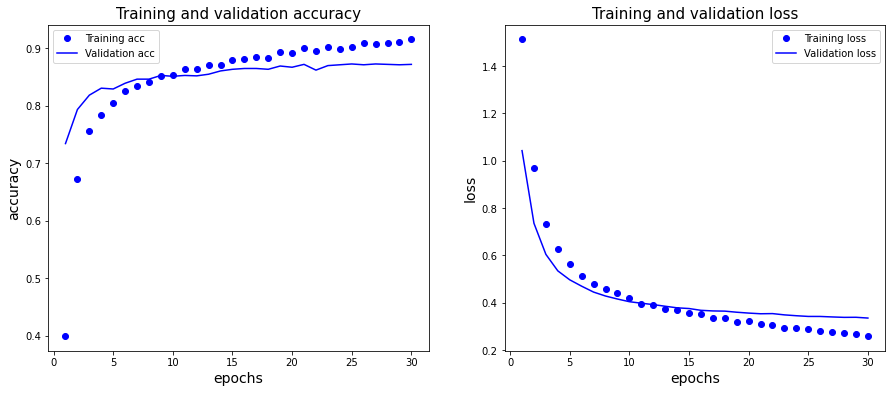

In [36]:
 plot_loss_accuracy(result)

In [37]:
pred = model2.predict(test_featuremap)
predictions = np.argmax(pred, axis=1)
predictions.shape

44/44 [==============================] - 0s 5ms/step


(1400,)

Number of total mislabeled images (179,)


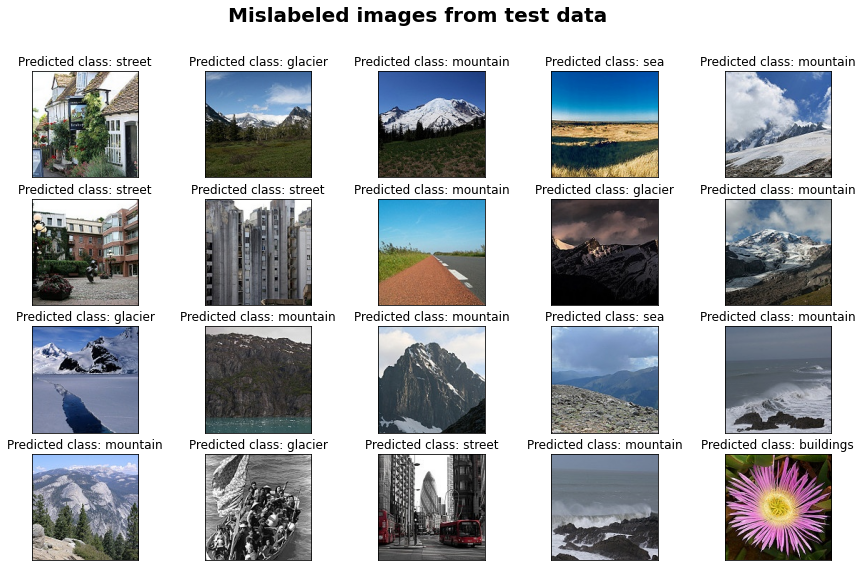

In [38]:
mislables_labels= mislabled_images(class_names, tst_images_norm, test_array, predictions)

In [39]:
def images_classifier(images_paths, class_names):
    file_array2 = []
    
    for file2 in images_paths:
        files2 = cv2.imread(file2)/255.0 
        file_array2.append(files2)
        
    file_array2 = np.array(file_array2)
    
    # run thorought the convolutional base and then model2
    img_arr = conv_base.predict(file_array2)
    
    # run img_arr of shape (9,4,4,512) through model2
    img_pred = model2.predict(img_arr)
    img_predf = np.argmax(img_pred, axis=1)
    print("shape of the predicted array:", img_predf.shape)
    
    # plot the 20 unseen images and predicted class
    plt.figure(figsize=(17,13))
    
    for idx, i in enumerate(img_predf):
        plt.subplot(4,5, idx+1)
        plt.imshow(file_array2[idx])
        plt.title(f"prediction of image: {class_names[i]}")
        plt.xticks([])
        plt.yticks([])
    
    plt.suptitle("Samples predicition of model2 on unseen data", size=20, weight='bold')
    plt.show()

1/1 [==============================] - 0s 26ms/step
shape of the predicted array: (20,)


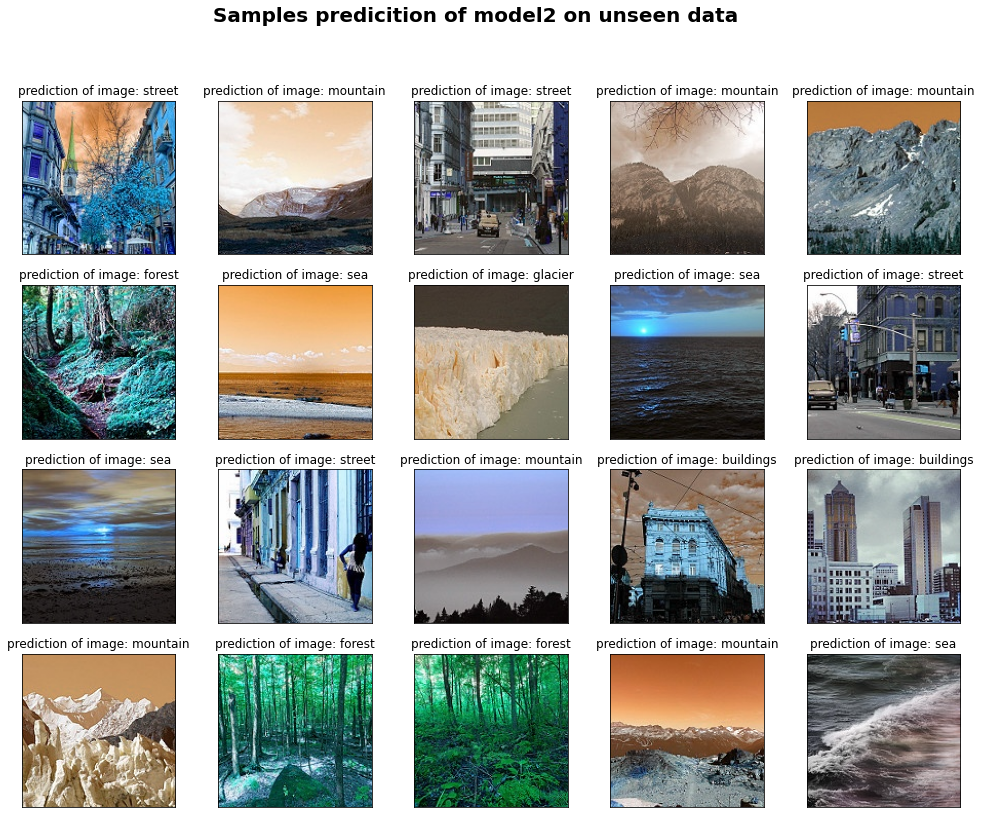

In [40]:
images_classifier(images_paths[:20], class_names)


In [45]:
model.save('c:/Users/sandl/image_classifier_cnn1.h5')

In [46]:
model2.save("c:/Users/sandl/image_classifier_cnn2.h5")

In [48]:
model3 = load_model('c:/Users/sandl/image_classifier_cnn1.h5')
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0